# MLNS Twitch Gamers Projects

Guillaume Levy, Clement Wang, Adberrahim Namouh, Gaspard Berthelier  

data can be found on : https://snap.stanford.edu/data/twitch_gamers.html

# Imports

In [1]:
# #Run when loading notebook on colab
# from google.colab import drive

# drive.mount("/content/drive")
# %cd /content/drive/My Drive/MLNS/twitch
# from tqdm.notebook import tqdm

# !pip install torch-geometric


#otherwiwe
from tqdm import tqdm

In [2]:
from functools import partial
from time import perf_counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import copy
import os
import torch
from torch_geometric.data import Data
import torch_geometric.transforms as T
from torch_geometric.nn import GATConv, GCNConv, SAGEConv, GINConv
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
import xgboost as xgb
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    mean_squared_error,
    r2_score
)

/raid/home/texttospeech/levy_gui/mlns/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data

In [4]:
data_folder = "data"
features_file = os.path.join(data_folder, "large_twitch_features.csv")
edges_file = os.path.join(data_folder, "large_twitch_edges.csv")

In [5]:
features = pd.read_csv(features_file).reset_index(drop=True)
num_nodes = np.max(features.numeric_id.values)
edges = pd.read_csv(edges_file).reset_index(drop=True)

print("Features : ", list(features.columns))
print("Features shape : ", features.shape)
print("Edges shape : ", edges.shape)

Features :  ['views', 'mature', 'life_time', 'created_at', 'updated_at', 'numeric_id', 'dead_account', 'language', 'affiliate']
Features shape :  (168114, 9)
Edges shape :  (6797557, 2)


In [6]:
from datetime import datetime


def get_days_since(str_date):
    date_obj = datetime.strptime(str_date, "%Y-%m-%d")
    today = datetime.today()
    days_difference = (today - date_obj).days
    return days_difference


features["created_since"] = features.created_at.apply(get_days_since)
features["updated_since"] = features.updated_at.apply(get_days_since)
features = features.drop(columns=["created_at", "updated_at"])


def min_log(x):
    return np.log(x + 1)


def make_ordinal(df_, col):
    df = df_.copy()
    unique_values = df[col].unique()
    mapping = {value: i for i, value in enumerate(unique_values)}
    df[col] = df[col].map(mapping)
    return df


def make_onehot(df_, col, keep=False):
    df = df_.copy()
    df = pd.concat((df, pd.get_dummies(df[[col]]).astype(int)), axis=1)
    if not keep:
        df = df.drop(columns=[col])
    return df


features["log_views"] = features.views.apply(min_log)
features.head()

,views,mature,life_time,numeric_id,dead_account,language,affiliate,created_since,updated_since,log_views
0,7879,1,969,0,0,EN,1,2980,2011,8.972083
1,500,0,2699,1,0,EN,0,4714,2015,6.216606
2,382502,1,3149,2,0,EN,1,5160,2011,12.854492
3,386,0,1344,3,0,EN,0,3366,2022,5.958425
4,2486,0,1784,4,0,EN,0,3796,2012,7.818832


In [7]:
vanilla_cols = [
    "views",
    "mature",
    "life_time",
    "dead_account",
    "affiliate",
    "created_since",
    "updated_since",
]  # basic columns without language (str object)

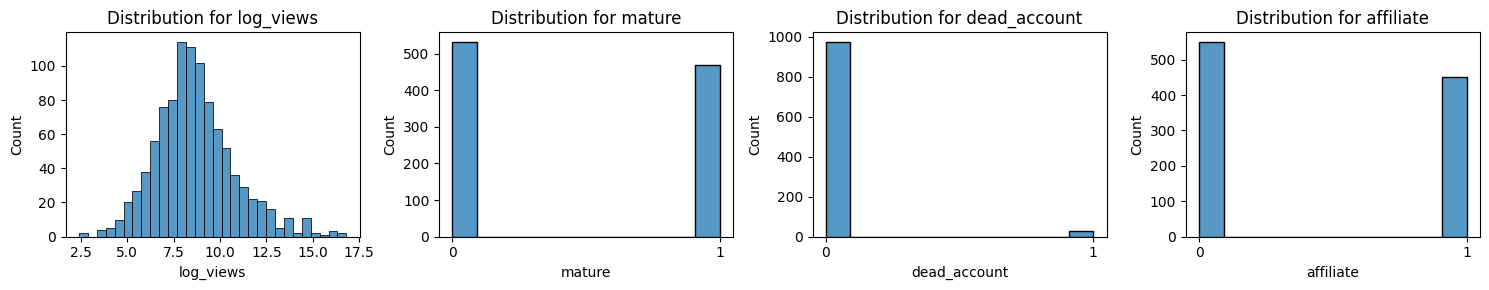

In [8]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))

for i, col in enumerate(["log_views", "mature", "dead_account", "affiliate"]):
    sns.histplot(features[0:1000][col], ax=axs[i])
    axs[i].set_title(f"Distribution for {col}")
    if col != "log_views":
        axs[i].set_xticks([0, 1])

fig.tight_layout()
plt.show()

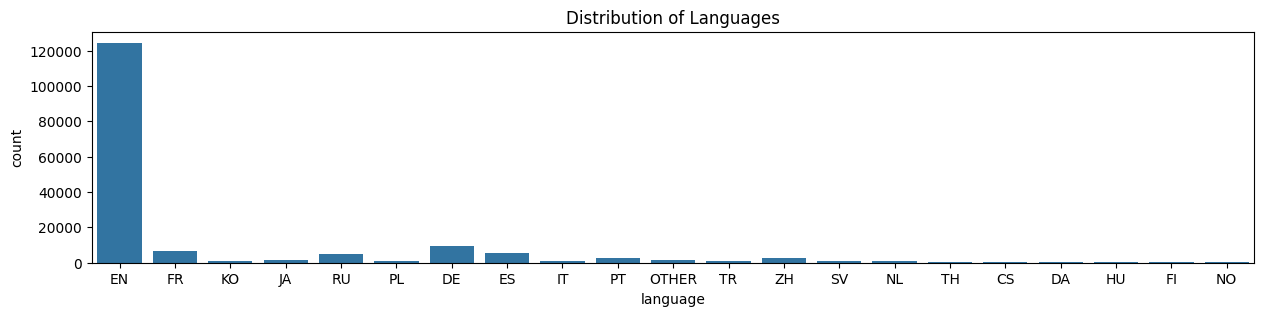

In [9]:
plt.figure(figsize=(15, 3))
sns.countplot(data=features, x="language")
plt.title("Distribution of Languages")
plt.show()

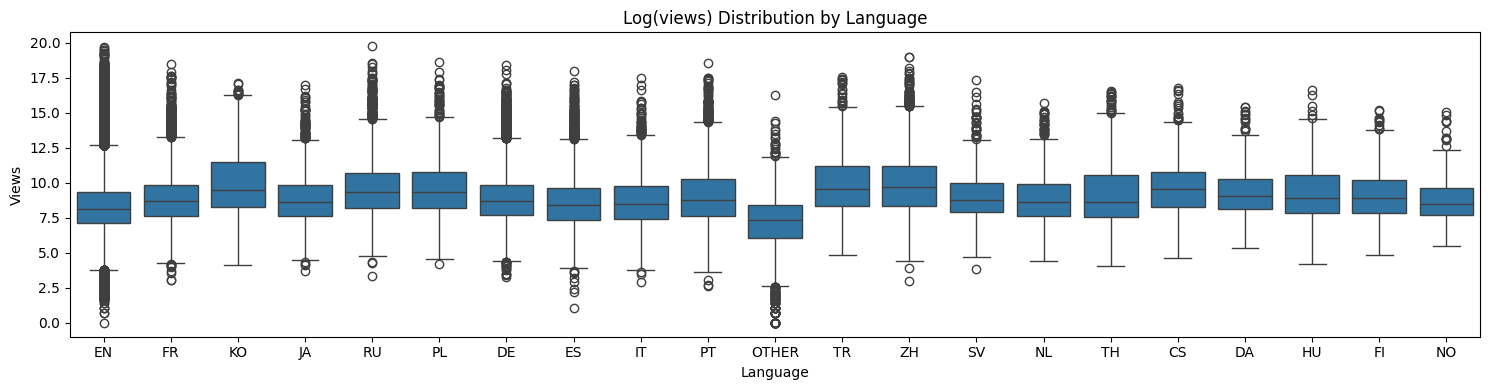

In [10]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=features, x="language", y="log_views")
plt.title("Log(views) Distribution by Language")
plt.xlabel("Language")
plt.ylabel("Views")
plt.tight_layout()
plt.show()

In [11]:
edges.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [12]:
do_graph = False #1 min
if do_graph:
    t1 = perf_counter()
    G = nx.from_edgelist(edges[["numeric_id_1", "numeric_id_2"]].values)
    nx.draw(G.subgraph(list(G.nodes())[0:100]), node_size=30, width=0.5)
    t2 = perf_counter()
    print(f"Done in {(t2-t1)/60:.3f} min")

In [13]:
do_degrees = False #4 min
if do_degrees:
    t1 = perf_counter()
    L = np.unique(G.degree(), return_counts=True)
    x, y = L[0], L[1]
    plt.bar(x, y)
    plt.title("Degree histogram")
    plt.xlabel("Degree")
    plt.ylabel("Counts")
    plt.yscale("log")
    plt.show()
    t2 = perf_counter()
    print(f"Done in {(t2-t1)/60:.3f} min")

In [14]:
do_degrees = False #4 min
if do_degrees:
    t1 = perf_counter()
    L = np.unique(G.degree(), return_counts=True)
    L = (np.log(1+L[0]), L[1])
    x, y = L[0], L[1]
    plt.bar(x, y)
    plt.title("Degree histogram")
    plt.xlabel("log-Degree")
    plt.ylabel("Counts")
    plt.yscale("log")
    plt.show()
    t2 = perf_counter()
    print(f"Done in {(t2-t1)/60:.3f} min")

# Naive predictions

In [15]:
def split_train_test(features, target_col, test_size=0.2, random_state=42):
    X = features.drop(columns=[target_col])
    y = features[target_col]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    return X_train, X_test, y_train, y_test


def fit_xgb_classification(
    X_train, X_test, y_train, y_test, print_report=True, binary=True
):

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, predictions)
    scores = {"accuracy": accuracy}

    if binary:
        scores["precision"] = precision_score(y_test, predictions)
        scores["recall"] = recall_score(y_test, predictions)
        scores["f1"] = f1_score(y_test, predictions)
        if print_report:
            print(classification_report(y_test, predictions))

    return model, scores


from sklearn.metrics import mean_squared_error, r2_score


def fit_xgb_regression(X_train, X_test, y_train, y_test, print_report=True):

    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    scores = {"mse": mse, "r2": r2}

    if print_report:
        print("Mean Squared Error:", round(mse, 0))
        print("R2 score:", round(r2, 3))

    return model, scores

In [16]:
# explicit

X_train, X_test, y_train, y_test = split_train_test(
    features.drop(columns=["log_views", "language"]), "mature"
)
model, scores = fit_xgb_classification(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.60      0.63      0.61     17715
           1       0.56      0.52      0.54     15908

    accuracy                           0.58     33623
   macro avg       0.58      0.58      0.58     33623
weighted avg       0.58      0.58      0.58     33623



In [17]:
# affiliate
X_train, X_test, y_train, y_test = split_train_test(
    features.drop(columns=["log_views", "language"]), "affiliate"
)
model, scores = fit_xgb_classification(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.81      0.75      0.78     17296
           1       0.75      0.81      0.78     16327

    accuracy                           0.78     33623
   macro avg       0.78      0.78      0.78     33623
weighted avg       0.78      0.78      0.78     33623



In [18]:
# language
X_train, X_test, y_train, y_test = split_train_test(
    make_ordinal(features.drop(columns=["log_views"]), "language"), "language"
)
model, scores = fit_xgb_classification(X_train, X_test, y_train, y_test, binary=False)
print("Accuracy : ", round(scores["accuracy"], 3))

Accuracy :  0.743


In [19]:
# views
X_train, X_test, y_train, y_test = split_train_test(
    features.drop(columns=["log_views", "language"]), "views"
)
model, scores = fit_xgb_regression(X_train, X_test, y_train, y_test)

Mean Squared Error: 14663797637727.0
R2 score: -0.072


In [20]:
# log views
X_train, X_test, y_train, y_test = split_train_test(
    features.drop(columns=["views", "language"]), "log_views"
)
model, scores = fit_xgb_regression(X_train, X_test, y_train, y_test)

Mean Squared Error: 3.0
R2 score: 0.338


# Graph models

In [21]:
n_epochs = 400
n_hidden_dim = 20

## Graph dataset

In [22]:
LIFE_TIME_MEAN, LIFE_TIME_STD = (
    features["life_time"].mean(),
    features["life_time"].std(),
)
CREATED_SINCE_MEAN, CREATED_SINCE_STD = (
    features["created_since"].mean(),
    features["created_since"].std(),
)
UPDATED_SINCE_MEAN, UPDATED_SINCE_STD = (
    features["updated_since"].mean(),
    features["updated_since"].std(),
)
LOG_VIEWS_MEAN, LOG_VIEWS_STD = (
    features["log_views"].mean(),
    features["log_views"].std(),
)


def process_features(features_df, target_col):
    normalized_features = features_df.copy()
    normalized_features = normalized_features.drop(
        columns=["views", "numeric_id", "language"]
    )

    normalized_features["life_time"] = (
        normalized_features["life_time"] - LIFE_TIME_MEAN
    ) / LIFE_TIME_STD
    normalized_features["created_since"] = (
        normalized_features["created_since"] - CREATED_SINCE_MEAN
    ) / CREATED_SINCE_STD
    normalized_features["updated_since"] = (
        normalized_features["updated_since"] - UPDATED_SINCE_MEAN
    ) / UPDATED_SINCE_STD
    normalized_features["log_views"] = (
        normalized_features["log_views"] - LOG_VIEWS_MEAN
    ) / LOG_VIEWS_STD

    if target_col == "language":
        target = make_ordinal(features_df, "language")["language"]
    else:
        normalized_features = pd.concat(
            [normalized_features, pd.get_dummies(features_df["language"], dtype=int)],
            axis=1,
        )
        target = features_df[target_col]
        normalized_features = normalized_features.drop(columns=[target_col])

    return normalized_features, target


def get_graph_data(edges, features_df, target_col):
    normalized_features, target = process_features(features_df, target_col)

    y = torch.tensor(target.values)
    if target_col != "language":
        y = y.view(features_df.shape[0], -1)
        y = y.float()

    data = Data(
        x=torch.tensor(normalized_features.values, dtype=torch.float),
        edge_index=torch.tensor(
            edges[["numeric_id_1", "numeric_id_2"]].values, dtype=torch.long
        ).T,
        y=y,
    )

    split = T.RandomNodeSplit(num_val=0.2, num_test=0.1)
    data = split(data)
    return data

In [23]:
def train_node_model(
    model,
    data,
    optimizer,
    loss_function,
    metric,
    apply_logit,
    n_epochs=10,
    test_every=1,
    print_every=1,
):
    metrics = {"train": [], "test": [], "x": []}
    best_metric = -np.inf if  metric != mean_squared_error else np.inf # Initialize with the worst possible metric value
    best_model = copy.deepcopy(
        model.state_dict()
    )  # Make a deep copy of the model's parameters

    for epoch in tqdm(range(1, n_epochs + 1)):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_function(out[data.train_mask], data.y[data.train_mask])
        # print("loss", loss.item())
        loss.backward()
        optimizer.step()

        if test_every != 0 and (
            epoch == n_epochs or epoch == 1 or epoch % test_every == 0
        ):
            train_metric_value = eval_node_model(
                model, data, data.train_mask, metric, apply_logit=apply_logit
            )
            val_metric_value = eval_node_model(
                model, data, data.val_mask, metric, apply_logit=apply_logit
            )
            metrics["train"].append(train_metric_value)
            metrics["test"].append(val_metric_value)
            metrics["x"].append(epoch)
            if (
                metric != mean_squared_error and val_metric_value > best_metric
            ):  # Check if the current model is the best one
                best_metric = val_metric_value
                best_model = copy.deepcopy(model.state_dict())  # Update best model
            elif metric == mean_squared_error and val_metric_value < best_metric:
                best_metric = val_metric_value
                best_model = copy.deepcopy(model.state_dict())

            if print_every != 0 and (
                epoch == n_epochs or epoch == 1 or epoch % print_every == 0
            ):
                print(
                    f"Epoch: {epoch:03d}, Train metric: {train_metric_value:.3f}, Val metric: {val_metric_value:.3f}"
                )

    model.load_state_dict(best_model)  # Restore the best model
    return model, metrics


def eval_node_model(model, data, mask, metric, apply_logit):
    with torch.no_grad():
        model.eval()
        pred = model(data)
        pred = apply_logit(pred)
        return metric(data.y[mask].cpu(), pred[mask].cpu())


def test_model(model, data, type_):
    score_dict = {}

    if type_ == "binary":
        metric_dict = {
            "accuracy": accuracy_score,
            "f1": f1_score,
            "recall": recall_score,
            "precision": precision_score,
        }
        apply_logit = lambda pred: pred > 0.0
    elif type_ == "multilabel":
        metric_dict = {
            "accuracy": accuracy_score,
            "f1": partial(f1_score, average="micro"),
            "recall": partial(recall_score, average="micro"),
            "precision": partial(precision_score, average="micro"),
        }
        apply_logit = lambda pred: pred.argmax(dim=1)
    elif type_ == "regression":
        metric_dict = {"mse": mean_squared_error, "r2": r2_score}
        apply_logit = lambda pred: pred

    for metric_name, metric in metric_dict.items():
        score = eval_node_model(
            model, data, data.test_mask, metric, apply_logit=apply_logit
        )
        score_dict[metric_name] = score
    return score_dict


def plot_results(metrics, metric_name):
    plt.plot(metrics["x"], metrics["train"], label="Train")
    plt.plot(metrics["x"], metrics["test"], label="Test")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(f"{metric_name}")
    plt.title(f"{metric_name} during training")
    plt.show()

In [24]:
def get_col_task(target_col):
    """Returns output_dim, loss, metric, metric_name, apply_logit"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def calculate_weights(labels):
        # Compute class weights inversely proportional to class frequencies
        class_weights = compute_class_weight(
            class_weight="balanced", classes=np.unique(labels), y=labels
        )
        return torch.tensor(class_weights, dtype=torch.float).to(device)

    if target_col in ["mature", "dead_account", "affiliate"]:
        return (
            1,
            torch.nn.BCEWithLogitsLoss(
                pos_weight=calculate_weights(features[target_col])[1]),
            accuracy_score,
            "Accuracy",
            lambda pred: pred > 0.0,
        )
    elif target_col == "language":
        return (
            len(features["language"].unique()),
            torch.nn.CrossEntropyLoss(weight=calculate_weights(features[target_col])),
            accuracy_score,
            "Accuracy",
            lambda pred: pred.argmax(dim=1),
        )
    elif target_col in ["log_views"]:
        return 1, torch.nn.MSELoss(), mean_squared_error, "MSE", lambda pred: pred
    else:
        raise ValueError(f"Invalid target column {target_col}")

In [25]:
def pipeline(
    model_class,
    model_params,
    edges,
    features,
    target_col,
    n_epochs=100,
    test_every=1,
    print_every=10,
    do_plot_results=True,
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data = get_graph_data(edges, features, target_col).to(device)
    num_features = data.x.shape[1]
    output_dim, loss_function, metric_function, metric_name, apply_logit = get_col_task(
        target_col
    )
    model = model_class(num_features, output_dim, **model_params).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    model, metrics = train_node_model(
        model,
        data,
        optimizer,
        loss_function,
        metric_function,
        apply_logit=apply_logit,
        n_epochs=n_epochs,
        test_every=test_every,
        print_every=print_every,
    )

    if do_plot_results:
        plot_results(metrics, metric_name)
    return model, metrics, data


def parameter_sweep(
    model_class,
    model_params,
    edges,
    features,
    target_col,
    parameter_name,
    parameter_list,
    n_epochs=100,
):
    test_scores = []
    for param in tqdm(parameter_list):
        params_kw = model_params.copy()
        params_kw[parameter_name] = param
        model, metrics, data = pipeline(
            model_class,
            params_kw,
            edges,
            features,
            target_col,
            print_every=0,
            n_epochs=n_epochs,
            test_every=10,
            do_plot_results=False,
        )
        test_scores.append(metrics["test"][-1])

    plt.plot(parameter_list, test_scores, linestyle="--", marker="o")
    plt.xlabel(f"{parameter_name}")
    plt.ylabel(get_col_task(target_col)[-2])
    plt.title(f"Parameter sweep for {parameter_name}")
    plt.show()

    return test_scores

## GCN

In [26]:
class GCNsmall(torch.nn.Module):
    def __init__(self, num_features, output_dim, hidden_dim=10):
        super(GCNsmall, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)

        return x

class GCNbig(torch.nn.Module):
    def __init__(self, num_features, output_dim, hidden_dim=10):
        super(GCNbig, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim * 2)
        self.conv4 = GCNConv(hidden_dim * 2, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)
        x = torch.relu(x)
        x = self.conv4(x, edge_index)

        return x

  1%|          | 3/400 [00:01<01:57,  3.39it/s]

Epoch: 001, Train metric: 0.484, Val metric: 0.486


 13%|█▎        | 51/400 [00:06<00:38,  8.99it/s]

Epoch: 050, Train metric: 0.651, Val metric: 0.654


 25%|██▌       | 101/400 [00:11<00:33,  8.98it/s]

Epoch: 100, Train metric: 0.666, Val metric: 0.665


 38%|███▊      | 151/400 [00:16<00:27,  8.97it/s]

Epoch: 150, Train metric: 0.671, Val metric: 0.670


 50%|█████     | 201/400 [00:21<00:22,  8.99it/s]

Epoch: 200, Train metric: 0.674, Val metric: 0.672


 63%|██████▎   | 251/400 [00:26<00:16,  8.98it/s]

Epoch: 250, Train metric: 0.675, Val metric: 0.674


 75%|███████▌  | 301/400 [00:31<00:11,  8.97it/s]

Epoch: 300, Train metric: 0.676, Val metric: 0.675


 88%|████████▊ | 351/400 [00:36<00:05,  8.98it/s]

Epoch: 350, Train metric: 0.678, Val metric: 0.678


100%|██████████| 400/400 [00:41<00:00,  9.58it/s]

Epoch: 400, Train metric: 0.674, Val metric: 0.672


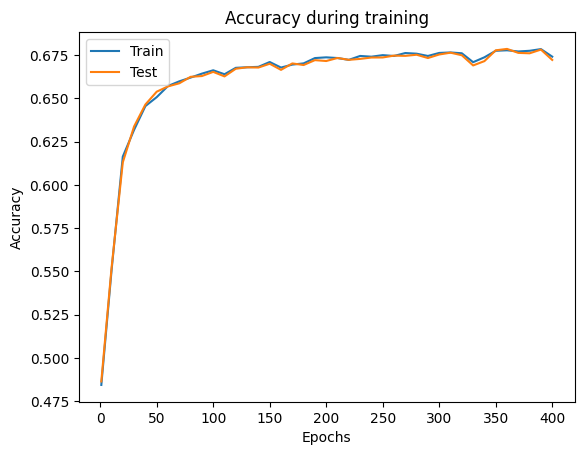

{'accuracy': 0.6753911129617512,
 'f1': 0.6591292398026111,
 'recall': 0.6406022340942205,
 'precision': 0.6787598095973241}

In [27]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GCNsmall,
    model_params,
    edges,
    features,
    "affiliate",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  1%|          | 3/400 [00:00<00:42,  9.40it/s]

Epoch: 001, Train metric: 0.489, Val metric: 0.491


 13%|█▎        | 51/400 [00:05<00:38,  8.97it/s]

Epoch: 050, Train metric: 0.610, Val metric: 0.611


 25%|██▌       | 101/400 [00:10<00:33,  8.99it/s]

Epoch: 100, Train metric: 0.610, Val metric: 0.612


 38%|███▊      | 151/400 [00:15<00:27,  8.91it/s]

Epoch: 150, Train metric: 0.624, Val metric: 0.624


 50%|█████     | 201/400 [00:20<00:22,  8.98it/s]

Epoch: 200, Train metric: 0.626, Val metric: 0.627


 63%|██████▎   | 251/400 [00:25<00:16,  8.98it/s]

Epoch: 250, Train metric: 0.627, Val metric: 0.626


 75%|███████▌  | 301/400 [00:30<00:11,  8.99it/s]

Epoch: 300, Train metric: 0.626, Val metric: 0.625


 88%|████████▊ | 351/400 [00:35<00:05,  8.98it/s]

Epoch: 350, Train metric: 0.633, Val metric: 0.632


100%|██████████| 400/400 [00:40<00:00,  9.76it/s]

Epoch: 400, Train metric: 0.633, Val metric: 0.631


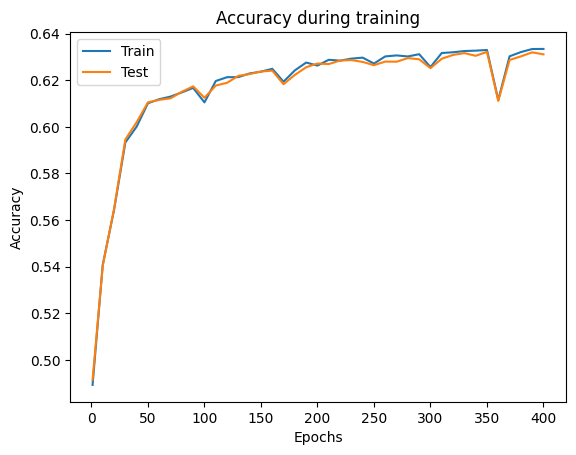

{'accuracy': 0.63089643685682,
 'f1': 0.595211690260291,
 'recall': 0.5731875863801985,
 'precision': 0.6189959294436906}

In [28]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GCNsmall,
    model_params,
    edges,
    features,
    "mature",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  1%|          | 3/400 [00:00<00:53,  7.36it/s]

Epoch: 001, Train metric: 0.737, Val metric: 0.739


 13%|█▎        | 52/400 [00:07<00:48,  7.21it/s]

Epoch: 050, Train metric: 0.740, Val metric: 0.742


 26%|██▌       | 102/400 [00:13<00:41,  7.19it/s]

Epoch: 100, Train metric: 0.761, Val metric: 0.763


 38%|███▊      | 152/400 [00:20<00:34,  7.16it/s]

Epoch: 150, Train metric: 0.775, Val metric: 0.777


 50%|█████     | 202/400 [00:27<00:27,  7.19it/s]

Epoch: 200, Train metric: 0.779, Val metric: 0.781


 63%|██████▎   | 252/400 [00:33<00:20,  7.19it/s]

Epoch: 250, Train metric: 0.786, Val metric: 0.788


 76%|███████▌  | 302/400 [00:40<00:13,  7.19it/s]

Epoch: 300, Train metric: 0.797, Val metric: 0.798


 88%|████████▊ | 352/400 [00:47<00:06,  7.19it/s]

Epoch: 350, Train metric: 0.808, Val metric: 0.808


100%|██████████| 400/400 [00:53<00:00,  7.45it/s]

Epoch: 400, Train metric: 0.814, Val metric: 0.815


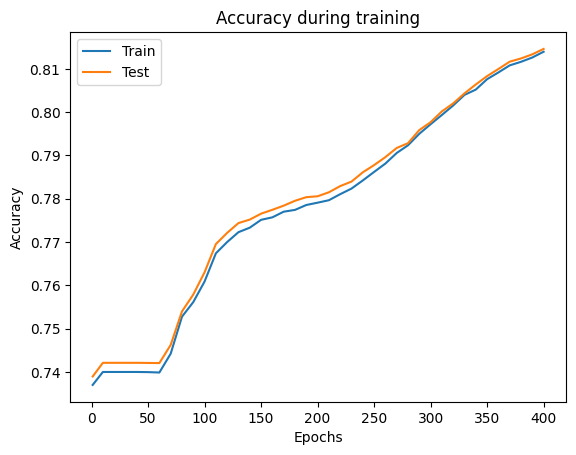

{'accuracy': 0.8108381416929391,
 'f1': 0.8108381416929391,
 'recall': 0.8108381416929391,
 'precision': 0.8108381416929391}

In [29]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GCNsmall,
    model_params,
    edges,
    features,
    "language",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "multilabel")

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 1/400 [00:00<02:25,  2.75it/s]

Epoch: 001, Train metric: 0.740, Val metric: 0.741


 12%|█▎        | 50/400 [00:09<01:29,  3.92it/s]

Epoch: 050, Train metric: 0.740, Val metric: 0.741


 25%|██▌       | 100/400 [00:19<01:16,  3.91it/s]

Epoch: 100, Train metric: 0.766, Val metric: 0.768


 38%|███▊      | 150/400 [00:29<01:03,  3.91it/s]

Epoch: 150, Train metric: 0.777, Val metric: 0.778


 50%|█████     | 200/400 [00:39<00:51,  3.91it/s]

Epoch: 200, Train metric: 0.786, Val metric: 0.787


 62%|██████▎   | 250/400 [00:48<00:38,  3.91it/s]

Epoch: 250, Train metric: 0.794, Val metric: 0.795


 75%|███████▌  | 300/400 [00:58<00:25,  3.91it/s]

Epoch: 300, Train metric: 0.816, Val metric: 0.817


 88%|████████▊ | 350/400 [01:08<00:12,  3.91it/s]

Epoch: 350, Train metric: 0.824, Val metric: 0.826


100%|██████████| 400/400 [01:17<00:00,  5.14it/s]

Epoch: 400, Train metric: 0.827, Val metric: 0.828


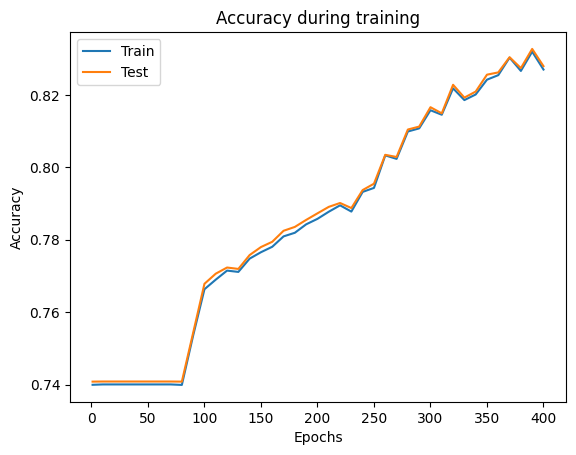

{'accuracy': 0.8322526916899649,
 'f1': 0.8322526916899649,
 'recall': 0.8322526916899649,
 'precision': 0.8322526916899649}

In [34]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GCNbig,
    model_params,
    edges,
    features,
    "language",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "multilabel")

  1%|          | 3/400 [00:00<00:40,  9.72it/s]

Epoch: 001, Train metric: 70.297, Val metric: 70.223


 13%|█▎        | 51/400 [00:05<00:38,  9.18it/s]

Epoch: 050, Train metric: 10.834, Val metric: 10.849


 25%|██▌       | 101/400 [00:10<00:32,  9.14it/s]

Epoch: 100, Train metric: 8.671, Val metric: 8.681


 38%|███▊      | 151/400 [00:15<00:27,  9.18it/s]

Epoch: 150, Train metric: 6.962, Val metric: 6.973


 50%|█████     | 201/400 [00:20<00:21,  9.19it/s]

Epoch: 200, Train metric: 5.891, Val metric: 5.921


 63%|██████▎   | 251/400 [00:25<00:16,  9.20it/s]

Epoch: 250, Train metric: 5.387, Val metric: 5.429


 75%|███████▌  | 301/400 [00:30<00:10,  9.19it/s]

Epoch: 300, Train metric: 4.996, Val metric: 5.040


 88%|████████▊ | 351/400 [00:35<00:05,  9.18it/s]

Epoch: 350, Train metric: 4.659, Val metric: 4.708


100%|██████████| 400/400 [00:40<00:00,  9.90it/s]

Epoch: 400, Train metric: 4.366, Val metric: 4.417


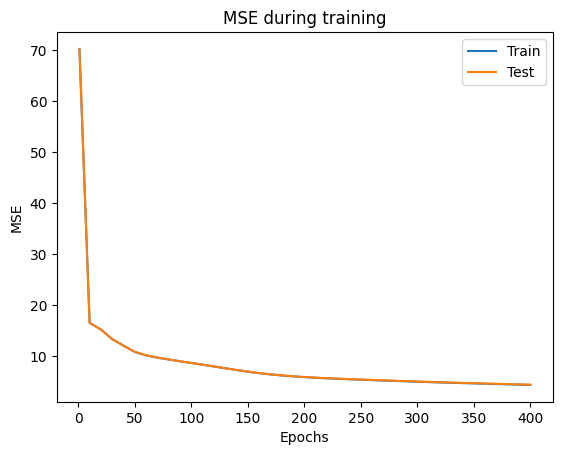

{'mse': 4.38988, 'r2': -0.09190343317412197}

In [31]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GCNsmall,
    model_params,
    edges,
    features,
    "log_views",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "regression")

  0%|          | 1/400 [00:00<02:01,  3.29it/s]

Epoch: 001, Train metric: 62.939, Val metric: 62.626


 12%|█▎        | 50/400 [00:08<01:14,  4.70it/s]

Epoch: 050, Train metric: 10.951, Val metric: 10.969


 25%|██▌       | 100/400 [00:16<01:03,  4.70it/s]

Epoch: 100, Train metric: 8.953, Val metric: 8.985


 38%|███▊      | 150/400 [00:24<00:53,  4.70it/s]

Epoch: 150, Train metric: 7.352, Val metric: 7.363


 50%|█████     | 200/400 [00:32<00:42,  4.70it/s]

Epoch: 200, Train metric: 6.611, Val metric: 6.608


 62%|██████▎   | 250/400 [00:40<00:31,  4.71it/s]

Epoch: 250, Train metric: 5.970, Val metric: 5.965


 75%|███████▌  | 300/400 [00:48<00:21,  4.70it/s]

Epoch: 300, Train metric: 5.467, Val metric: 5.463


 88%|████████▊ | 350/400 [00:56<00:10,  4.70it/s]

Epoch: 350, Train metric: 5.064, Val metric: 5.056


100%|██████████| 400/400 [01:04<00:00,  6.19it/s]

Epoch: 400, Train metric: 4.667, Val metric: 4.659


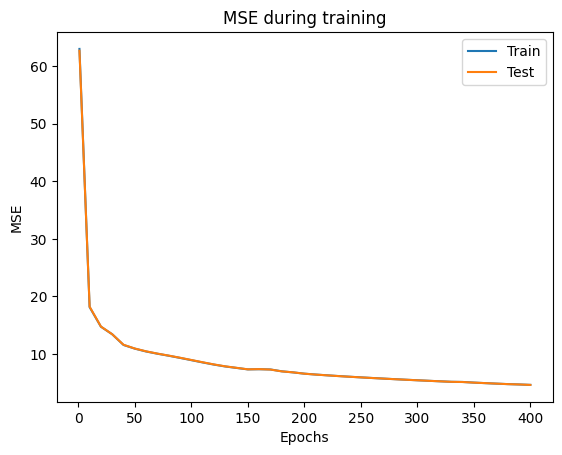

{'mse': 4.662175, 'r2': -0.11912280957818644}

In [32]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GCNbig,
    model_params,
    edges,
    features,
    "log_views",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "regression")

100%|██████████| 6/6 [04:03<00:00, 40.54s/it]


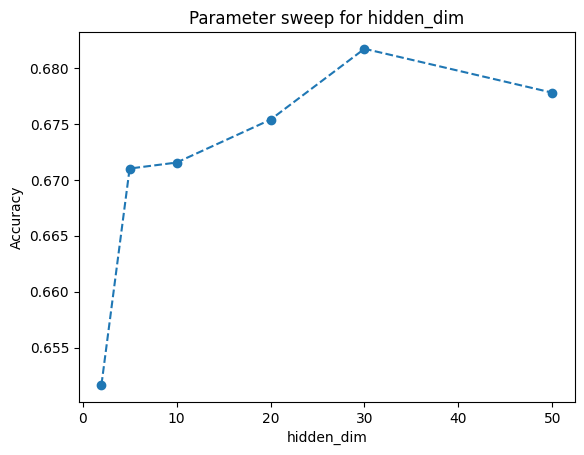

In [33]:
other_params = {"hidden_dim": None}
parameter_name = "hidden_dim"
parameter_list = [2, 5, 10, 20, 30, 50]
test_scores = parameter_sweep(
    GCNsmall,
    other_params,
    edges,
    features,
    "affiliate",
    "hidden_dim",
    parameter_list,
    n_epochs=n_epochs,
)

100%|██████████| 6/6 [06:22<00:00, 63.77s/it]


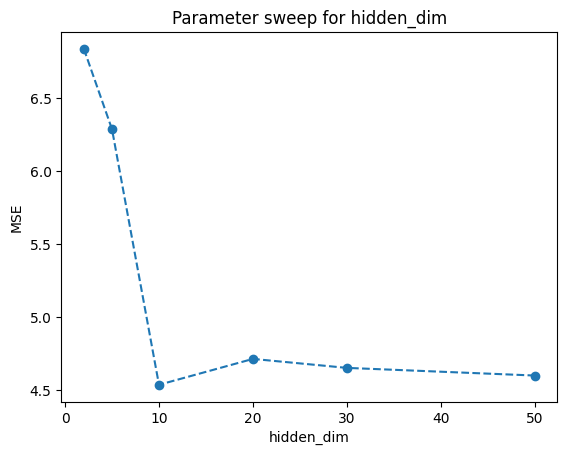

In [38]:
other_params = {"hidden_dim": None}
parameter_name = "hidden_dim"
parameter_list = [2, 5, 10, 20, 30, 50]
test_scores = parameter_sweep(
    GCNbig,
    other_params,
    edges,
    features,
    "log_views",
    "hidden_dim",
    parameter_list,
    n_epochs=n_epochs,
)

## GIN

In [39]:
class GIN(torch.nn.Module):
    def __init__(self, num_features, output_dim, hidden_dim=10):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            torch.nn.Sequential(torch.nn.Linear(num_features, hidden_dim), torch.nn.ReLU(),
                       torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()))
        self.conv2 = GINConv(
            torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
                       torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU()))
        self.conv3 = GINConv(
            torch.nn.Sequential(torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.ReLU(),
                       torch.nn.Linear(hidden_dim, output_dim)))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.conv2(x, edge_index)
        x = self.conv3(x, edge_index)

        return x #F.log_softmax(x, dim=-1)

  1%|          | 4/400 [00:00<00:27, 14.39it/s]

Epoch: 001, Train metric: 0.486, Val metric: 0.488


  2%|▏         | 6/400 [00:00<00:25, 15.50it/s]

 13%|█▎        | 53/400 [00:03<00:24, 14.45it/s]

Epoch: 050, Train metric: 0.519, Val metric: 0.520


 26%|██▌       | 103/400 [00:06<00:20, 14.46it/s]

Epoch: 100, Train metric: 0.609, Val metric: 0.610


 38%|███▊      | 153/400 [00:10<00:17, 14.48it/s]

Epoch: 150, Train metric: 0.612, Val metric: 0.614


 51%|█████     | 203/400 [00:13<00:13, 14.49it/s]

Epoch: 200, Train metric: 0.617, Val metric: 0.619


 63%|██████▎   | 253/400 [00:16<00:10, 14.47it/s]

Epoch: 250, Train metric: 0.631, Val metric: 0.628


 76%|███████▌  | 303/400 [00:20<00:06, 14.45it/s]

Epoch: 300, Train metric: 0.639, Val metric: 0.638


 88%|████████▊ | 353/400 [00:23<00:03, 14.50it/s]

Epoch: 350, Train metric: 0.630, Val metric: 0.629


100%|██████████| 400/400 [00:26<00:00, 14.90it/s]


Epoch: 400, Train metric: 0.639, Val metric: 0.638


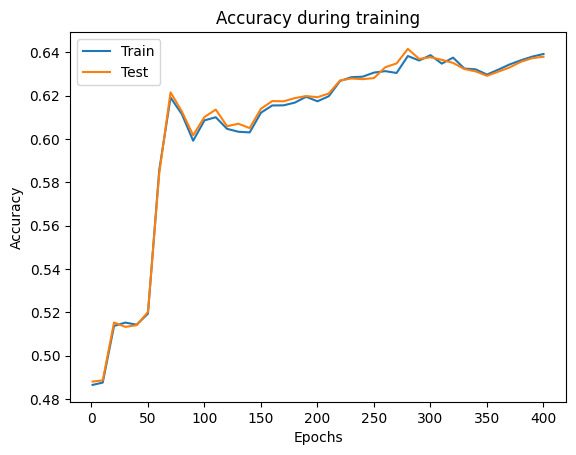

{'accuracy': 0.63006364880138,
 'f1': 0.5881184184383071,
 'recall': 0.5493010021031796,
 'precision': 0.6328392246294184}

In [40]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GIN,
    model_params,
    edges,
    features,
    "affiliate",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  1%|          | 4/400 [00:00<00:27, 14.46it/s]

Epoch: 001, Train metric: 0.472, Val metric: 0.471


 13%|█▎        | 53/400 [00:03<00:23, 14.49it/s]

Epoch: 050, Train metric: 0.529, Val metric: 0.529


 26%|██▌       | 103/400 [00:06<00:20, 14.48it/s]

Epoch: 100, Train metric: 0.593, Val metric: 0.594


 38%|███▊      | 153/400 [00:10<00:17, 14.48it/s]

Epoch: 150, Train metric: 0.598, Val metric: 0.597


 51%|█████     | 203/400 [00:13<00:13, 14.42it/s]

Epoch: 200, Train metric: 0.602, Val metric: 0.601


 63%|██████▎   | 253/400 [00:16<00:10, 14.48it/s]

Epoch: 250, Train metric: 0.607, Val metric: 0.606


 76%|███████▌  | 303/400 [00:20<00:06, 14.47it/s]

Epoch: 300, Train metric: 0.585, Val metric: 0.581


 88%|████████▊ | 353/400 [00:23<00:03, 14.50it/s]

Epoch: 350, Train metric: 0.607, Val metric: 0.606


100%|██████████| 400/400 [00:26<00:00, 14.90it/s]


Epoch: 400, Train metric: 0.614, Val metric: 0.612


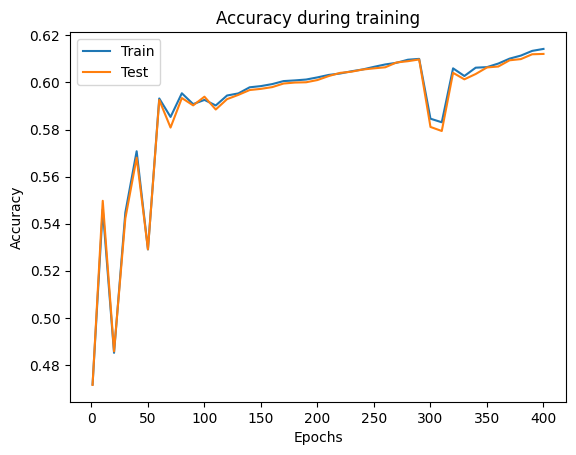

{'accuracy': 0.6132294331092737,
 'f1': 0.5263694638694638,
 'recall': 0.46002037178507765,
 'precision': 0.615083418454205}

In [41]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GIN,
    model_params,
    edges,
    features,
    "mature",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  1%|          | 4/400 [00:00<00:23, 17.19it/s]

Epoch: 001, Train metric: 0.004, Val metric: 0.004


 13%|█▎        | 53/400 [00:03<00:20, 16.72it/s]

Epoch: 050, Train metric: 0.739, Val metric: 0.740


 26%|██▌       | 103/400 [00:06<00:17, 16.69it/s]

Epoch: 100, Train metric: 0.739, Val metric: 0.740


 38%|███▊      | 153/400 [00:08<00:14, 16.73it/s]

Epoch: 150, Train metric: 0.739, Val metric: 0.740


 51%|█████     | 203/400 [00:11<00:11, 16.73it/s]

Epoch: 200, Train metric: 0.739, Val metric: 0.740


 63%|██████▎   | 253/400 [00:14<00:08, 16.72it/s]

Epoch: 250, Train metric: 0.739, Val metric: 0.740


 76%|███████▌  | 303/400 [00:17<00:05, 16.72it/s]

Epoch: 300, Train metric: 0.739, Val metric: 0.740


 88%|████████▊ | 353/400 [00:20<00:02, 16.72it/s]

Epoch: 350, Train metric: 0.739, Val metric: 0.740


100%|██████████| 400/400 [00:23<00:00, 17.09it/s]


Epoch: 400, Train metric: 0.739, Val metric: 0.740


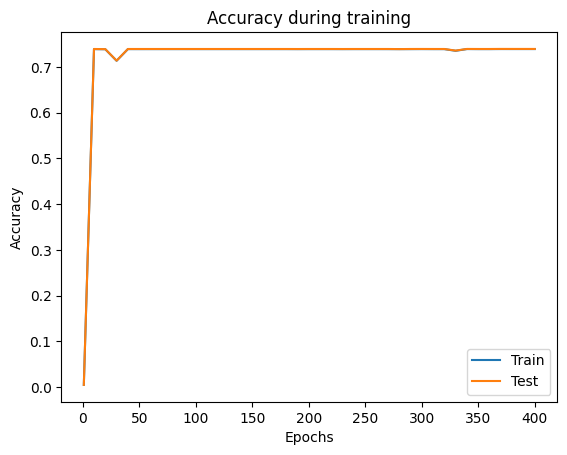

{'accuracy': 0.7455832490631135,
 'f1': 0.7455832490631135,
 'recall': 0.7455832490631135,
 'precision': 0.7455832490631135}

In [42]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GIN,
    model_params,
    edges,
    features,
    "language",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "multilabel")

  1%|          | 4/400 [00:00<00:26, 14.96it/s]

Epoch: 001, Train metric: 3049900.500, Val metric: 2961440.000


 13%|█▎        | 53/400 [00:03<00:23, 14.85it/s]

Epoch: 050, Train metric: 182.654, Val metric: 180.344


 26%|██▌       | 103/400 [00:06<00:20, 14.81it/s]

Epoch: 100, Train metric: 50.787, Val metric: 50.619


 38%|███▊      | 153/400 [00:10<00:16, 14.87it/s]

Epoch: 150, Train metric: 5592.340, Val metric: 5498.244


 51%|█████     | 203/400 [00:13<00:13, 14.86it/s]

Epoch: 200, Train metric: 42.758, Val metric: 42.683


 63%|██████▎   | 253/400 [00:16<00:09, 14.82it/s]

Epoch: 250, Train metric: 38.001, Val metric: 37.839


 76%|███████▌  | 303/400 [00:19<00:06, 14.84it/s]

Epoch: 300, Train metric: 34.669, Val metric: 34.444


 88%|████████▊ | 353/400 [00:23<00:03, 14.87it/s]

Epoch: 350, Train metric: 31.819, Val metric: 31.749


100%|██████████| 400/400 [00:26<00:00, 15.23it/s]


Epoch: 400, Train metric: 28.996, Val metric: 28.977


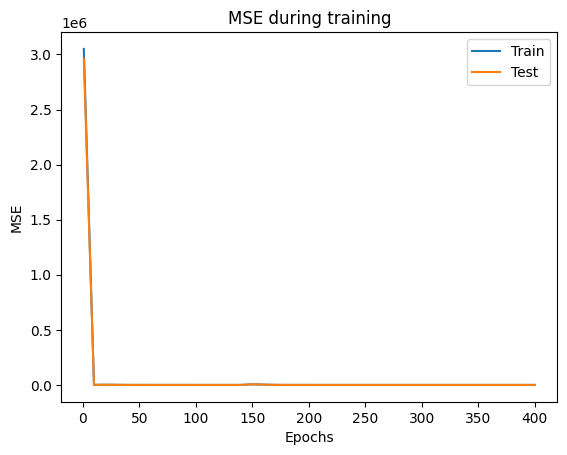

{'mse': 28.59878, 'r2': -6.103919697540781}

In [43]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GIN,
    model_params,
    edges,
    features,
    "log_views",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "regression")

## GAT

In [47]:
class GAT(torch.nn.Module):
    def __init__(self, num_features, output_dim, hidden_dim=10):
        super(GAT, self).__init__()
        self.conv1 = GATConv(
            num_features, hidden_dim, heads=4, concat=True
        )  # output : hidden_dim * num_heads
        self.conv2 = GATConv(
            hidden_dim * 4, hidden_dim, heads=4, concat=True
        )
        self.conv3 = GATConv(hidden_dim * 4, output_dim, heads=4, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

  0%|          | 2/400 [00:00<02:34,  2.57it/s]

Epoch: 001, Train metric: 0.515, Val metric: 0.513


 13%|█▎        | 51/400 [00:19<02:19,  2.50it/s]

Epoch: 050, Train metric: 0.688, Val metric: 0.687


 25%|██▌       | 101/400 [00:38<01:59,  2.50it/s]

Epoch: 100, Train metric: 0.743, Val metric: 0.736


 38%|███▊      | 151/400 [00:58<01:39,  2.50it/s]

Epoch: 150, Train metric: 0.763, Val metric: 0.756


 50%|█████     | 201/400 [01:17<01:19,  2.50it/s]

Epoch: 200, Train metric: 0.777, Val metric: 0.769


 63%|██████▎   | 251/400 [01:36<00:59,  2.50it/s]

Epoch: 250, Train metric: 0.787, Val metric: 0.778


 75%|███████▌  | 301/400 [01:55<00:39,  2.50it/s]

Epoch: 300, Train metric: 0.789, Val metric: 0.780


 88%|████████▊ | 351/400 [02:14<00:19,  2.50it/s]

Epoch: 350, Train metric: 0.791, Val metric: 0.783


100%|██████████| 400/400 [02:33<00:00,  2.60it/s]

Epoch: 400, Train metric: 0.793, Val metric: 0.783


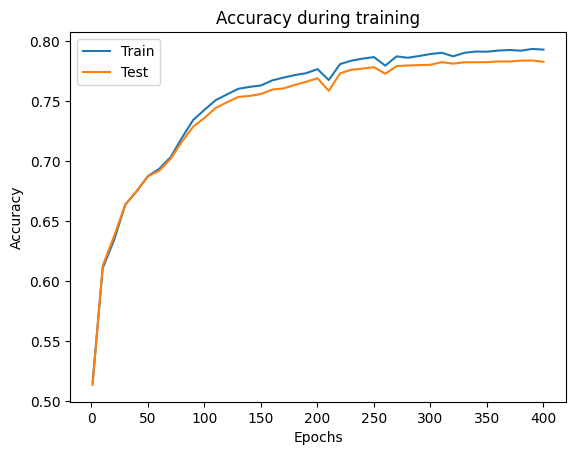

{'accuracy': 0.7814526203081316,
 'f1': 0.7795247239558329,
 'recall': 0.7966392738869128,
 'precision': 0.7631300669721537}

In [48]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GAT,
    model_params,
    edges,
    features,
    "affiliate",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  0%|          | 2/400 [00:00<02:23,  2.77it/s]

Epoch: 001, Train metric: 0.530, Val metric: 0.528


 13%|█▎        | 51/400 [00:19<02:19,  2.50it/s]

Epoch: 050, Train metric: 0.618, Val metric: 0.618


 25%|██▌       | 101/400 [00:38<01:59,  2.50it/s]

Epoch: 100, Train metric: 0.637, Val metric: 0.635


 38%|███▊      | 151/400 [00:57<01:39,  2.50it/s]

Epoch: 150, Train metric: 0.640, Val metric: 0.638


 50%|█████     | 201/400 [01:17<01:19,  2.50it/s]

Epoch: 200, Train metric: 0.644, Val metric: 0.641


 63%|██████▎   | 251/400 [01:36<00:59,  2.50it/s]

Epoch: 250, Train metric: 0.645, Val metric: 0.639


 75%|███████▌  | 301/400 [01:55<00:39,  2.50it/s]

Epoch: 300, Train metric: 0.644, Val metric: 0.639


 88%|████████▊ | 351/400 [02:14<00:19,  2.50it/s]

Epoch: 350, Train metric: 0.649, Val metric: 0.644


100%|██████████| 400/400 [02:33<00:00,  2.60it/s]

Epoch: 400, Train metric: 0.651, Val metric: 0.646


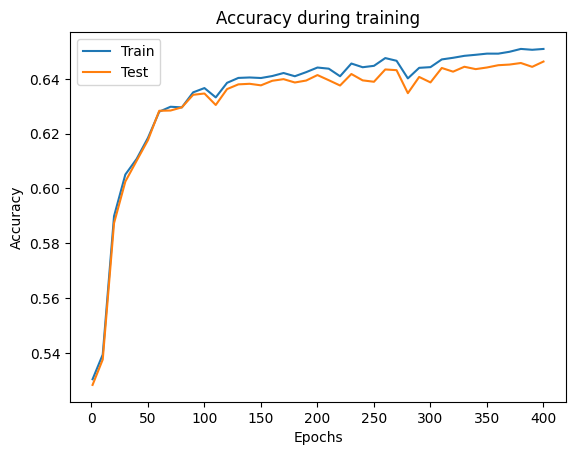

{'accuracy': 0.6454107429659152,
 'f1': 0.6008169825219313,
 'recall': 0.5670585261028948,
 'precision': 0.6388493306750214}

In [49]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GAT,
    model_params,
    edges,
    features,
    "mature",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  0%|          | 1/400 [00:01<06:54,  1.04s/it]

Epoch: 001, Train metric: 0.740, Val metric: 0.742


 12%|█▎        | 50/400 [00:27<04:05,  1.43it/s]

Epoch: 050, Train metric: 0.740, Val metric: 0.742


 25%|██▌       | 100/400 [00:53<03:30,  1.43it/s]

Epoch: 100, Train metric: 0.812, Val metric: 0.813


 38%|███▊      | 150/400 [01:20<02:55,  1.43it/s]

Epoch: 150, Train metric: 0.846, Val metric: 0.847


 50%|█████     | 200/400 [01:47<02:20,  1.43it/s]

Epoch: 200, Train metric: 0.876, Val metric: 0.876


 62%|██████▎   | 250/400 [02:13<01:45,  1.43it/s]

Epoch: 250, Train metric: 0.890, Val metric: 0.890


 75%|███████▌  | 300/400 [02:40<01:10,  1.43it/s]

Epoch: 300, Train metric: 0.896, Val metric: 0.894


 88%|████████▊ | 350/400 [03:06<00:35,  1.43it/s]

Epoch: 350, Train metric: 0.903, Val metric: 0.901


100%|██████████| 400/400 [03:33<00:00,  1.87it/s]

Epoch: 400, Train metric: 0.906, Val metric: 0.904


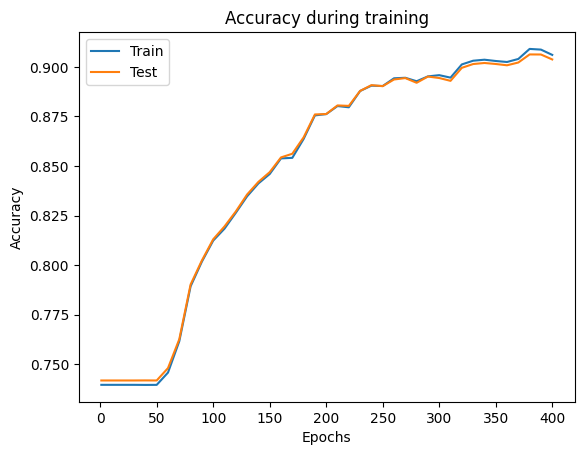

{'accuracy': 0.9067277377907322,
 'f1': 0.9067277377907322,
 'recall': 0.9067277377907322,
 'precision': 0.9067277377907322}

In [50]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GAT,
    model_params,
    edges,
    features,
    "language",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "multilabel")

  0%|          | 2/400 [00:00<02:21,  2.81it/s]

Epoch: 001, Train metric: 74.939, Val metric: 75.315


 13%|█▎        | 51/400 [00:19<02:18,  2.52it/s]

Epoch: 050, Train metric: 3.906, Val metric: 4.010


 25%|██▌       | 101/400 [00:38<01:58,  2.52it/s]

Epoch: 100, Train metric: 3.490, Val metric: 3.587


 38%|███▊      | 151/400 [00:57<01:38,  2.52it/s]

Epoch: 150, Train metric: 2.843, Val metric: 2.910


 50%|█████     | 201/400 [01:16<01:19,  2.51it/s]

Epoch: 200, Train metric: 2.456, Val metric: 2.503


 63%|██████▎   | 251/400 [01:35<00:59,  2.52it/s]

Epoch: 250, Train metric: 2.208, Val metric: 2.254


 75%|███████▌  | 301/400 [01:54<00:39,  2.52it/s]

Epoch: 300, Train metric: 2.072, Val metric: 2.129


 88%|████████▊ | 351/400 [02:14<00:19,  2.52it/s]

Epoch: 350, Train metric: 1.982, Val metric: 2.036


100%|██████████| 400/400 [02:32<00:00,  2.62it/s]

Epoch: 400, Train metric: 1.897, Val metric: 1.959


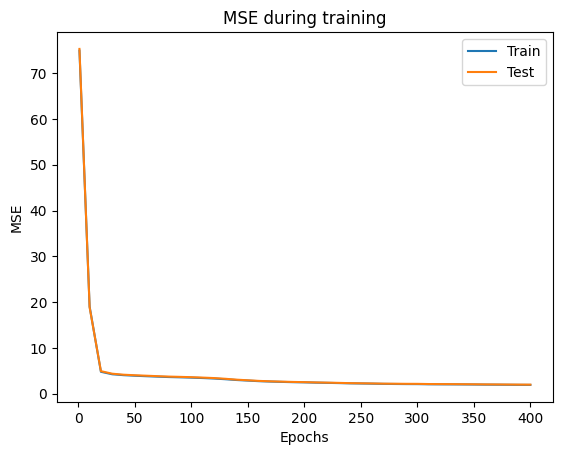

{'mse': 1.8842764, 'r2': 0.5396789715512368}

In [51]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GAT,
    model_params,
    edges,
    features,
    "log_views",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "regression")

## GraphSAGE

In [52]:
class GraphSage(torch.nn.Module):
    def __init__(self, num_features, output_dim, hidden_dim=10):
        super(GraphSage, self).__init__()
        self.conv1 = SAGEConv(num_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, output_dim)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.relu(x)
        x = self.conv3(x, edge_index)

        return x

  1%|          | 4/400 [00:00<00:27, 14.31it/s]

Epoch: 001, Train metric: 0.520, Val metric: 0.518


 13%|█▎        | 53/400 [00:03<00:24, 14.35it/s]

Epoch: 050, Train metric: 0.795, Val metric: 0.790


 26%|██▌       | 103/400 [00:06<00:20, 14.34it/s]

Epoch: 100, Train metric: 0.803, Val metric: 0.798


 38%|███▊      | 153/400 [00:10<00:17, 14.32it/s]

Epoch: 150, Train metric: 0.805, Val metric: 0.800


 51%|█████     | 203/400 [00:13<00:13, 14.35it/s]

Epoch: 200, Train metric: 0.807, Val metric: 0.801


 63%|██████▎   | 253/400 [00:17<00:10, 14.32it/s]

Epoch: 250, Train metric: 0.808, Val metric: 0.801


 76%|███████▌  | 303/400 [00:20<00:06, 14.34it/s]

Epoch: 300, Train metric: 0.809, Val metric: 0.802


 88%|████████▊ | 353/400 [00:23<00:03, 14.35it/s]

Epoch: 350, Train metric: 0.809, Val metric: 0.802


100%|██████████| 400/400 [00:27<00:00, 14.77it/s]


Epoch: 400, Train metric: 0.810, Val metric: 0.803


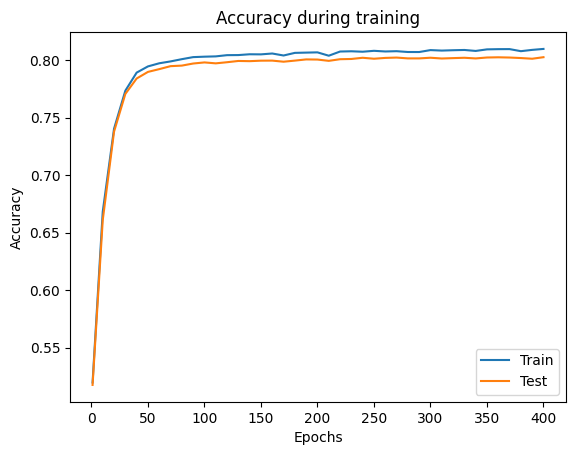

{'accuracy': 0.8060793528047112,
 'f1': 0.806872037914692,
 'recall': 0.8406369584001975,
 'precision': 0.7757147738922429}

In [53]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GraphSage,
    model_params,
    edges,
    features,
    "affiliate",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  1%|          | 4/400 [00:00<00:27, 14.30it/s]

Epoch: 001, Train metric: 0.498, Val metric: 0.499


 13%|█▎        | 53/400 [00:03<00:24, 14.34it/s]

Epoch: 050, Train metric: 0.632, Val metric: 0.632


 26%|██▌       | 103/400 [00:06<00:20, 14.36it/s]

Epoch: 100, Train metric: 0.637, Val metric: 0.638


 38%|███▊      | 153/400 [00:10<00:17, 14.37it/s]

Epoch: 150, Train metric: 0.638, Val metric: 0.637


 51%|█████     | 203/400 [00:13<00:13, 14.37it/s]

Epoch: 200, Train metric: 0.641, Val metric: 0.639


 63%|██████▎   | 253/400 [00:17<00:10, 14.39it/s]

Epoch: 250, Train metric: 0.642, Val metric: 0.640


 76%|███████▌  | 303/400 [00:20<00:06, 14.36it/s]

Epoch: 300, Train metric: 0.636, Val metric: 0.633


 88%|████████▊ | 353/400 [00:23<00:03, 14.38it/s]

Epoch: 350, Train metric: 0.648, Val metric: 0.644


100%|██████████| 400/400 [00:27<00:00, 14.80it/s]


Epoch: 400, Train metric: 0.644, Val metric: 0.641


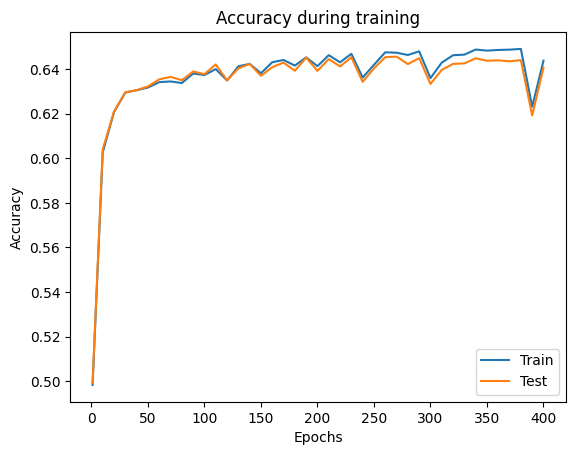

{'accuracy': 0.6523704717149486,
 'f1': 0.6195807837521156,
 'recall': 0.6058561425843412,
 'precision': 0.6339416544558412}

In [54]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GraphSage,
    model_params,
    edges,
    features,
    "mature",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "binary")

  1%|          | 4/400 [00:00<00:23, 16.87it/s]

Epoch: 001, Train metric: 0.630, Val metric: 0.631


 13%|█▎        | 53/400 [00:03<00:21, 16.51it/s]

Epoch: 050, Train metric: 0.741, Val metric: 0.740


 26%|██▌       | 103/400 [00:06<00:18, 16.48it/s]

Epoch: 100, Train metric: 0.743, Val metric: 0.743


 38%|███▊      | 153/400 [00:09<00:14, 16.47it/s]

Epoch: 150, Train metric: 0.770, Val metric: 0.767


 51%|█████     | 203/400 [00:12<00:11, 16.48it/s]

Epoch: 200, Train metric: 0.783, Val metric: 0.782


 63%|██████▎   | 253/400 [00:14<00:08, 16.47it/s]

Epoch: 250, Train metric: 0.788, Val metric: 0.787


 76%|███████▌  | 303/400 [00:17<00:05, 16.47it/s]

Epoch: 300, Train metric: 0.795, Val metric: 0.793


 88%|████████▊ | 353/400 [00:20<00:02, 16.47it/s]

Epoch: 350, Train metric: 0.802, Val metric: 0.800


100%|██████████| 400/400 [00:23<00:00, 16.86it/s]


Epoch: 400, Train metric: 0.811, Val metric: 0.809


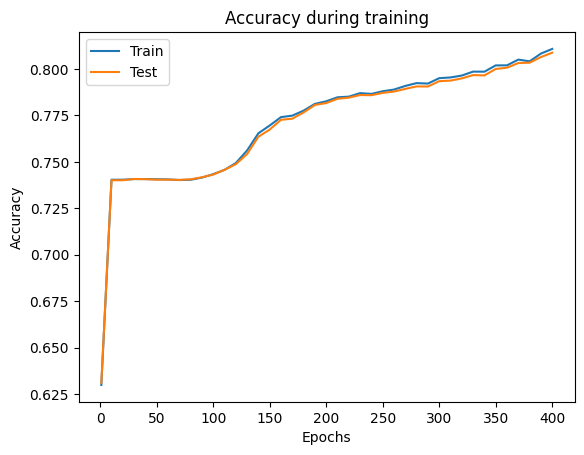

{'accuracy': 0.8076259591933853,
 'f1': 0.8076259591933853,
 'recall': 0.8076259591933853,
 'precision': 0.8076259591933853}

In [55]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GraphSage,
    model_params,
    edges,
    features,
    "language",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "multilabel")

  1%|          | 4/400 [00:00<00:26, 14.83it/s]

Epoch: 001, Train metric: 75.407, Val metric: 75.238


 13%|█▎        | 53/400 [00:03<00:23, 14.74it/s]

Epoch: 050, Train metric: 3.512, Val metric: 3.504


 26%|██▌       | 103/400 [00:06<00:20, 14.75it/s]

Epoch: 100, Train metric: 2.985, Val metric: 3.000


 38%|███▊      | 153/400 [00:10<00:16, 14.74it/s]

Epoch: 150, Train metric: 2.587, Val metric: 2.588


 51%|█████     | 203/400 [00:13<00:13, 14.74it/s]

Epoch: 200, Train metric: 2.449, Val metric: 2.450


 63%|██████▎   | 253/400 [00:16<00:09, 14.78it/s]

Epoch: 250, Train metric: 2.357, Val metric: 2.357


 76%|███████▌  | 303/400 [00:19<00:06, 14.76it/s]

Epoch: 300, Train metric: 2.272, Val metric: 2.270


 88%|████████▊ | 353/400 [00:23<00:03, 14.75it/s]

Epoch: 350, Train metric: 2.185, Val metric: 2.182


100%|██████████| 400/400 [00:26<00:00, 15.14it/s]


Epoch: 400, Train metric: 2.093, Val metric: 2.093


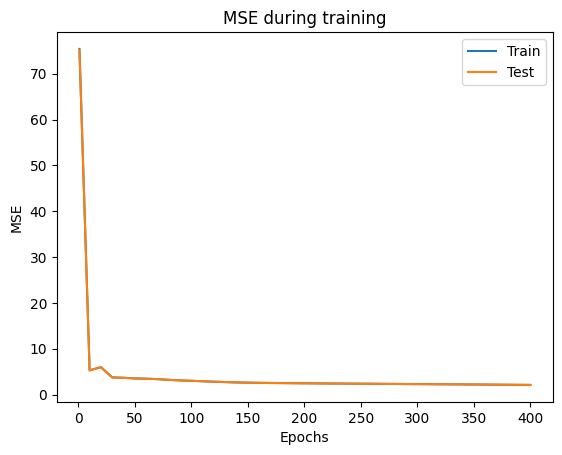

{'mse': 2.1442516, 'r2': 0.47578536836640717}

In [56]:
model_params = {"hidden_dim": n_hidden_dim}
model, metrics, data = pipeline(
    GraphSage,
    model_params,
    edges,
    features,
    "log_views",
    n_epochs=n_epochs,
    test_every=10,
    print_every=50,
)
test_model(model, data, "regression")